In [1]:
import torch 
import numpy as np 
import sklearn as sk 
import pandas as pd 
import seaborn as sns 
import torchvision
import matplotlib.pyplot as plt

In [2]:
from torchvision import transforms

In [3]:
Train_set = torchvision.datasets.FashionMNIST(root='./data' , train=True , download=True , transform=torchvision.transforms.ToTensor())
Test_set = torchvision.datasets.FashionMNIST(root='./data' , train=False , download=True , transform=torchvision.transforms.ToTensor())

In [4]:
print("Train Data info: ")
print("Features:" , Train_set.data.shape , "Labels:" , Train_set.targets.shape)
print("Test Data info: ")
print("Features:" , Test_set.data.shape , "Labels:" , Test_set.targets.shape)
print("Data type")
print(type(Train_set.data))
# Labels are numbers, need to one-hot
print(Test_set.targets[0])

Train Data info: 
Features: torch.Size([60000, 28, 28]) Labels: torch.Size([60000])
Test Data info: 
Features: torch.Size([10000, 28, 28]) Labels: torch.Size([10000])
Data type
<class 'torch.Tensor'>
tensor(9)


In [5]:
# TO Tensor + Normalize + Flatten 
transform = transforms.Compose([transforms.ToTensor() ,
                                transforms.Normalize(mean=0 , std=1) , 
                                transforms.Lambda(lambda x: x.view(-1))])

In [6]:
import torch.nn.functional as F  
def collate_fn(batch):
    images, labels = zip(*batch)  
    images = torch.stack(images)  
    labels = torch.tensor(labels)  
    one_hot_labels = F.one_hot(labels, num_classes=10).float() 
    return images, one_hot_labels

In [7]:
Train_set = torchvision.datasets.FashionMNIST(root='./data' , train=True , download=True , transform=transform)
Test_set = torchvision.datasets.FashionMNIST(root='./data' , train=False , download=True , transform=transform)

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(Train_set, batch_size=32, shuffle=True , collate_fn=collate_fn)
test_loader = DataLoader(Test_set, batch_size = 32 , shuffle=True , collate_fn=collate_fn)


In [9]:

data_iter = iter(test_loader)
images, labels = data_iter.__next__()
print("Transformed batch of images shape (flattened):", images.shape) 
print("One-hot encoded labels shape:", labels.shape)
print("One-hot encoded label:" , labels[0])

data_iter = iter(train_loader)
images, labels = data_iter.__next__()
print("Transformed batch of images shape (flattened):", images.shape) 
print("One-hot encoded labels shape:", labels.shape)


Transformed batch of images shape (flattened): torch.Size([32, 784])
One-hot encoded labels shape: torch.Size([32, 10])
One-hot encoded label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Transformed batch of images shape (flattened): torch.Size([32, 784])
One-hot encoded labels shape: torch.Size([32, 10])


In [10]:
print("len of MLP input: "  , images.shape[1])
print("len of MLP output"  , labels.shape[1])

in_mlp =  images.shape[1]
out_mlp = labels.shape[1]

len of MLP input:  784
len of MLP output 10


In [11]:
import torch.nn as nn
import torch.optim as optim

In [87]:
class MLP(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=100, output_size=out_mlp):
        super(MLP, self).__init__()# 100 hidden layers
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.dropout = nn.Dropout(p=0.30)  # 30% dropout             
        self.fc2 = nn.Linear(hidden_size, output_size) 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)      
        x = self.fc2(x)
        x = self.flatten(x)   
        return x

In [88]:
device = 'cpu'

In [89]:
torch.random.manual_seed(42)
model = MLP()
model.to(device=device)
loss_fnc = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
landa = 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=landa)

In [90]:

from torchsummary import summary

summary(model , images)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 100]                 78,500
├─Dropout: 1-2                           [-1, 100]                 --
├─Linear: 1-3                            [-1, 10]                  1,010
├─Flatten: 1-4                           [-1, 10]                  --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.40


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 100]                 78,500
├─Dropout: 1-2                           [-1, 100]                 --
├─Linear: 1-3                            [-1, 10]                  1,010
├─Flatten: 1-4                           [-1, 10]                  --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.40

In [91]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:

        optimizer.zero_grad() 

        outputs = model(inputs.to(device))

        loss = loss_fnc(outputs.cpu(), labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        pred = torch.argmax(outputs.cpu(), dim=1)
        act = torch.argmax(labels, dim=1)
        correct_train += ( pred == act).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train


    model.eval() 
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            loss = loss_fnc(outputs.cpu(), labels)
        
            val_loss += loss.item()

            pred = torch.argmax(outputs.cpu(), dim=1)
            act = torch.argmax(labels, dim=1)

            correct_val += (pred == act).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = correct_val / total_val
                

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


Epoch [1/30], Train Loss: 0.5828, Val Loss: 0.4508, Train Acc: 0.7965, Val Acc: 0.8390
Epoch [2/30], Train Loss: 0.4352, Val Loss: 0.4109, Train Acc: 0.8446, Val Acc: 0.8491
Epoch [3/30], Train Loss: 0.4087, Val Loss: 0.4036, Train Acc: 0.8528, Val Acc: 0.8547
Epoch [4/30], Train Loss: 0.3875, Val Loss: 0.3819, Train Acc: 0.8597, Val Acc: 0.8604
Epoch [5/30], Train Loss: 0.3786, Val Loss: 0.3697, Train Acc: 0.8621, Val Acc: 0.8678
Epoch [6/30], Train Loss: 0.3660, Val Loss: 0.3725, Train Acc: 0.8653, Val Acc: 0.8665
Epoch [7/30], Train Loss: 0.3620, Val Loss: 0.3665, Train Acc: 0.8673, Val Acc: 0.8666
Epoch [8/30], Train Loss: 0.3532, Val Loss: 0.3654, Train Acc: 0.8708, Val Acc: 0.8675
Epoch [9/30], Train Loss: 0.3477, Val Loss: 0.3787, Train Acc: 0.8730, Val Acc: 0.8670
Epoch [10/30], Train Loss: 0.3433, Val Loss: 0.3708, Train Acc: 0.8749, Val Acc: 0.8646
Epoch [11/30], Train Loss: 0.3433, Val Loss: 0.3693, Train Acc: 0.8746, Val Acc: 0.8648
Epoch [12/30], Train Loss: 0.3355, Val Lo

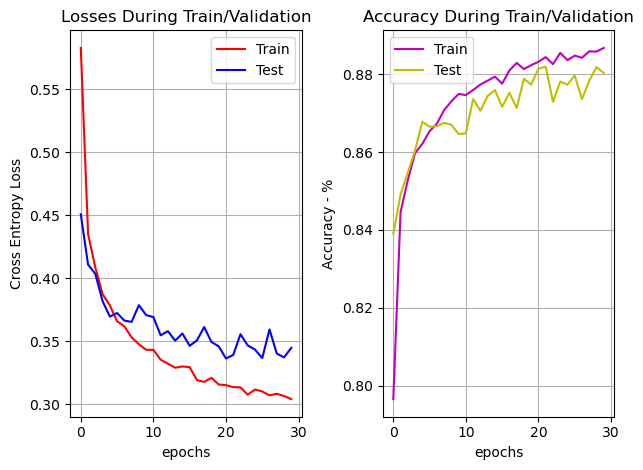

In [92]:
figure , ax = plt.subplots(1, 2)

ax[0].plot(train_losses , color = 'r' , label = "Train")
ax[0].plot(val_losses , color = 'b' , label = "Test")
ax[0].grid()
ax[0].set_title("Losses During Train/Validation")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("Cross Entropy Loss")
ax[0].legend()


ax[1].plot(train_accuracies , color = 'm' , label = "Train")
ax[1].plot(val_accuracies , color = 'y' , label = "Test")
ax[1].grid()
ax[1].set_title("Accuracy During Train/Validation")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("Accuracy - %")
ax[1].legend()

figure.tight_layout()

In [97]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)

In [98]:
train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

In [107]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

In [115]:
cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

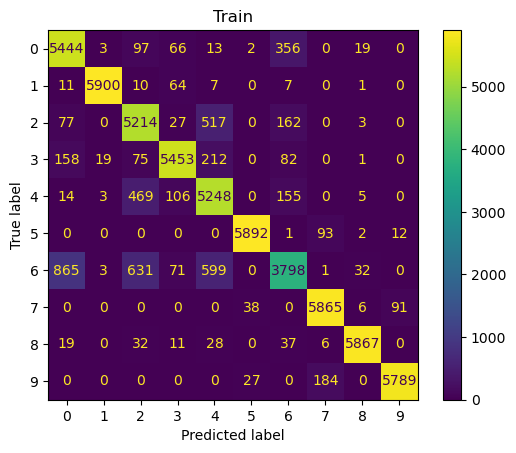

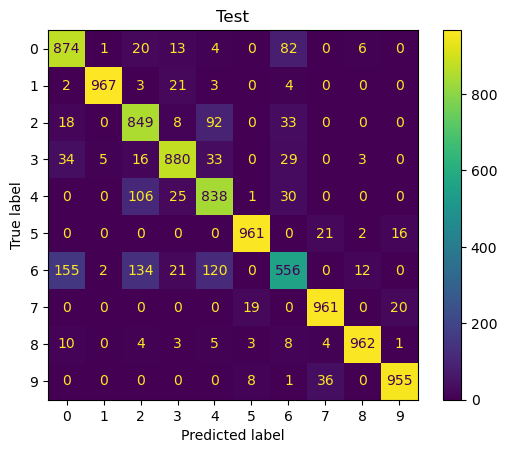

In [139]:
disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train")
plt.show()
disp_v.plot()
plt.title("Test")
plt.show()

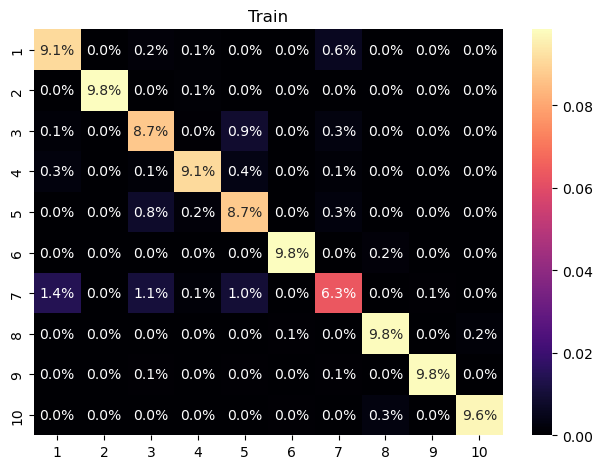

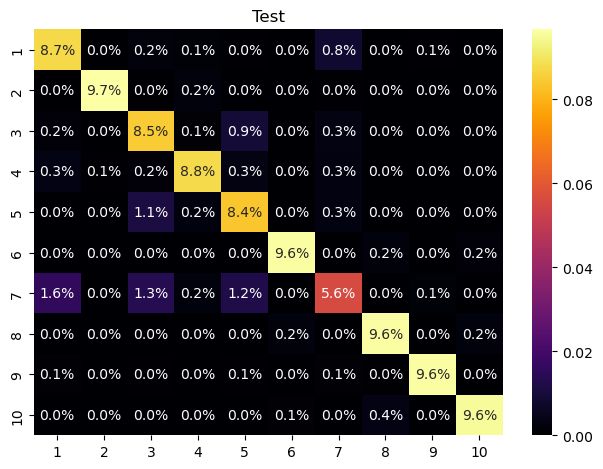

In [140]:
sns.heatmap(cf_matrix_t/np.sum(cf_matrix_t), annot=True,xticklabels=np.arange(1,11) , yticklabels=np.arange(1,11), 
            fmt='0.00001%', cmap='magma')
plt.title("Train")
plt.tight_layout()
plt.show()
sns.heatmap(cf_matrix_v/np.sum(cf_matrix_v), annot=True,xticklabels=np.arange(1,11) , yticklabels=np.arange(1,11),
            fmt='.00001%', cmap='inferno')
plt.title("Test")
plt.tight_layout()
plt.show()

In [146]:
from sklearn.metrics import classification_report

print("Train Report:")
report_train = classification_report(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1) , )
print(report_train)

Train Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      6000
           1       1.00      0.98      0.99      6000
           2       0.80      0.87      0.83      6000
           3       0.94      0.91      0.92      6000
           4       0.79      0.87      0.83      6000
           5       0.99      0.98      0.99      6000
           6       0.83      0.63      0.72      6000
           7       0.95      0.98      0.97      6000
           8       0.99      0.98      0.98      6000
           9       0.98      0.96      0.97      6000

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



In [147]:

print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)

Test Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.75      0.85      0.80      1000
           3       0.91      0.88      0.89      1000
           4       0.77      0.84      0.80      1000
           5       0.97      0.96      0.96      1000
           6       0.75      0.56      0.64      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [166]:
np.fill_diagonal(cf_matrix_t, 0)

most_confused_indices = np.unravel_index(np.argmax(cf_matrix_t, axis=None), cf_matrix_t.shape)

confusion_value = cf_matrix_t[most_confused_indices]

print("For test")
print("Confused classes for each class are" , np.argmax(cf_matrix_t, axis=1))

print("The most confused classes are: " , most_confused_indices[0], "and" , most_confused_indices[1])
print("Confusion value: "  , confusion_value)

For test
Confused classes for each class are [6 3 4 4 2 7 0 9 6 7]
The most confused classes are:  6 and 0
Confusion value:  865


In [167]:
np.fill_diagonal(cf_matrix_v, 0)

most_confused_indices = np.unravel_index(np.argmax(cf_matrix_v, axis=None), cf_matrix_v.shape)

confusion_value = cf_matrix_v[most_confused_indices]
print("For train")
print("Confused classes for each class are" , np.argmax(cf_matrix_v, axis=1))

print("The most confused classes are: " , most_confused_indices[0], "and" , most_confused_indices[1])
print("Confusion value: "  , confusion_value)

For train
Confused classes for each class are [6 3 4 0 2 7 0 9 0 7]
The most confused classes are:  6 and 0
Confusion value:  155


# Defining More Complex Models for reaching better/more stable results

In [172]:
class MLP_1(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=150, output_size=out_mlp):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.dropout = nn.Dropout(p=0.30)  # 30% dropout             
        self.fc2 = nn.Linear(hidden_size, output_size) 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)      
        x = self.fc2(x)
        x = self.flatten(x)   
        return x
    

class MLP_2(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=200, output_size=out_mlp):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.dropout = nn.Dropout(p=0.30)  # 30% dropout             
        self.fc2 = nn.Linear(hidden_size, output_size) 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)      
        x = self.fc2(x)
        x = self.flatten(x)   
        return x
    


class MLP_3(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=50, output_size=out_mlp):
        super(MLP_3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.dropout = nn.Dropout(p=0.30)  # 30% dropout             
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size) 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)      
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.flatten(x)   
        return x
    

class MLP_4(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=100, output_size=out_mlp):
        super(MLP_4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.dropout = nn.Dropout(p=0.30)  # 30% dropout             
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size) 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)      
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.flatten(x)   
        return x
    

class MLP_5(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=50, output_size=out_mlp):
        super(MLP_5, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.dropout = nn.Dropout(p=0.30)  # 30% dropout             
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, hidden_size) 
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.flatten = nn.Flatten()


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)      
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.flatten(x)   
        return x

    

In [187]:
torch.random.manual_seed(42)
model_1 = MLP_1()
model_1.to(device=device)
loss_fnc_1 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
landa = 0.0001
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001, weight_decay=landa)


model_2 = MLP_2()
model_2.to(device=device)
loss_fnc_2 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001, weight_decay=landa)

model_3 = MLP_3()
model_3.to(device=device)
loss_fnc_3 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001, weight_decay=landa)

model_4 = MLP_4()
model_4.to(device=device)
loss_fnc_4 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.001, weight_decay=landa)

model_5 = MLP_5()
model_5.to(device=device)
loss_fnc_5 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_5 = optim.Adam(model_5.parameters(), lr=0.001, weight_decay=landa)

In [188]:
def train_loop(model , num_epochs , optimizer , loss_fnc):  
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:

            optimizer.zero_grad() 

            outputs = model(inputs.to(device))

            loss = loss_fnc(outputs.cpu(), labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            pred = torch.argmax(outputs.cpu(), dim=1)
            act = torch.argmax(labels, dim=1)
            correct_train += ( pred == act).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train


        model.eval() 
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(device))
                loss = loss_fnc(outputs.cpu(), labels)
            
                val_loss += loss.item()

                pred = torch.argmax(outputs.cpu(), dim=1)
                act = torch.argmax(labels, dim=1)

                correct_val += (pred == act).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_acc = correct_val / total_val
                    

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses , val_losses , train_accuracies , val_accuracies

In [189]:
info_1 = train_loop(model_1 , 30 , optimizer_1 , loss_fnc_1)

Epoch [1/30], Train Loss: 0.5631, Val Loss: 0.4553, Train Acc: 0.8006, Val Acc: 0.8316
Epoch [2/30], Train Loss: 0.4236, Val Loss: 0.4143, Train Acc: 0.8467, Val Acc: 0.8511
Epoch [3/30], Train Loss: 0.3944, Val Loss: 0.3911, Train Acc: 0.8570, Val Acc: 0.8583
Epoch [4/30], Train Loss: 0.3753, Val Loss: 0.3729, Train Acc: 0.8622, Val Acc: 0.8664
Epoch [5/30], Train Loss: 0.3633, Val Loss: 0.3695, Train Acc: 0.8681, Val Acc: 0.8699
Epoch [6/30], Train Loss: 0.3530, Val Loss: 0.3566, Train Acc: 0.8709, Val Acc: 0.8732
Epoch [7/30], Train Loss: 0.3440, Val Loss: 0.3548, Train Acc: 0.8723, Val Acc: 0.8730
Epoch [8/30], Train Loss: 0.3382, Val Loss: 0.3532, Train Acc: 0.8743, Val Acc: 0.8736
Epoch [9/30], Train Loss: 0.3340, Val Loss: 0.3447, Train Acc: 0.8766, Val Acc: 0.8785
Epoch [10/30], Train Loss: 0.3294, Val Loss: 0.3417, Train Acc: 0.8778, Val Acc: 0.8763
Epoch [11/30], Train Loss: 0.3264, Val Loss: 0.3392, Train Acc: 0.8797, Val Acc: 0.8792
Epoch [12/30], Train Loss: 0.3214, Val Lo

In [194]:
info_2 = train_loop(model_2 , 30 , optimizer_2 , loss_fnc_2)

Epoch [1/30], Train Loss: 0.5489, Val Loss: 0.4309, Train Acc: 0.8052, Val Acc: 0.8477
Epoch [2/30], Train Loss: 0.4143, Val Loss: 0.4028, Train Acc: 0.8501, Val Acc: 0.8559
Epoch [3/30], Train Loss: 0.3860, Val Loss: 0.3819, Train Acc: 0.8577, Val Acc: 0.8626
Epoch [4/30], Train Loss: 0.3676, Val Loss: 0.3740, Train Acc: 0.8650, Val Acc: 0.8635
Epoch [5/30], Train Loss: 0.3531, Val Loss: 0.3847, Train Acc: 0.8697, Val Acc: 0.8609
Epoch [6/30], Train Loss: 0.3451, Val Loss: 0.3578, Train Acc: 0.8729, Val Acc: 0.8731
Epoch [7/30], Train Loss: 0.3369, Val Loss: 0.3586, Train Acc: 0.8754, Val Acc: 0.8717
Epoch [8/30], Train Loss: 0.3315, Val Loss: 0.3602, Train Acc: 0.8777, Val Acc: 0.8733
Epoch [9/30], Train Loss: 0.3270, Val Loss: 0.3623, Train Acc: 0.8793, Val Acc: 0.8717
Epoch [10/30], Train Loss: 0.3233, Val Loss: 0.3514, Train Acc: 0.8805, Val Acc: 0.8746
Epoch [11/30], Train Loss: 0.3208, Val Loss: 0.3574, Train Acc: 0.8799, Val Acc: 0.8661
Epoch [12/30], Train Loss: 0.3179, Val Lo

In [195]:
info_3 = train_loop(model_3 , 30 , optimizer_3 , loss_fnc_3)

Epoch [1/30], Train Loss: 0.7371, Val Loss: 0.4922, Train Acc: 0.7339, Val Acc: 0.8262
Epoch [2/30], Train Loss: 0.5235, Val Loss: 0.4423, Train Acc: 0.8146, Val Acc: 0.8371
Epoch [3/30], Train Loss: 0.4878, Val Loss: 0.4214, Train Acc: 0.8260, Val Acc: 0.8486
Epoch [4/30], Train Loss: 0.4675, Val Loss: 0.4250, Train Acc: 0.8338, Val Acc: 0.8452
Epoch [5/30], Train Loss: 0.4531, Val Loss: 0.3956, Train Acc: 0.8400, Val Acc: 0.8571
Epoch [6/30], Train Loss: 0.4436, Val Loss: 0.3950, Train Acc: 0.8433, Val Acc: 0.8573
Epoch [7/30], Train Loss: 0.4381, Val Loss: 0.3952, Train Acc: 0.8436, Val Acc: 0.8614
Epoch [8/30], Train Loss: 0.4314, Val Loss: 0.3978, Train Acc: 0.8447, Val Acc: 0.8520
Epoch [9/30], Train Loss: 0.4258, Val Loss: 0.3884, Train Acc: 0.8476, Val Acc: 0.8600
Epoch [10/30], Train Loss: 0.4232, Val Loss: 0.3895, Train Acc: 0.8483, Val Acc: 0.8625
Epoch [11/30], Train Loss: 0.4189, Val Loss: 0.3914, Train Acc: 0.8516, Val Acc: 0.8583
Epoch [12/30], Train Loss: 0.4183, Val Lo

In [196]:
info_4 = train_loop(model_4 , 30 , optimizer_4 , loss_fnc_4)

Epoch [1/30], Train Loss: 0.6352, Val Loss: 0.4416, Train Acc: 0.7711, Val Acc: 0.8397
Epoch [2/30], Train Loss: 0.4652, Val Loss: 0.4188, Train Acc: 0.8318, Val Acc: 0.8529
Epoch [3/30], Train Loss: 0.4330, Val Loss: 0.3919, Train Acc: 0.8436, Val Acc: 0.8580
Epoch [4/30], Train Loss: 0.4115, Val Loss: 0.3800, Train Acc: 0.8497, Val Acc: 0.8624
Epoch [5/30], Train Loss: 0.3980, Val Loss: 0.3733, Train Acc: 0.8559, Val Acc: 0.8656
Epoch [6/30], Train Loss: 0.3909, Val Loss: 0.3858, Train Acc: 0.8581, Val Acc: 0.8562
Epoch [7/30], Train Loss: 0.3860, Val Loss: 0.3602, Train Acc: 0.8604, Val Acc: 0.8729
Epoch [8/30], Train Loss: 0.3814, Val Loss: 0.3664, Train Acc: 0.8627, Val Acc: 0.8686
Epoch [9/30], Train Loss: 0.3742, Val Loss: 0.3605, Train Acc: 0.8650, Val Acc: 0.8707
Epoch [10/30], Train Loss: 0.3660, Val Loss: 0.3594, Train Acc: 0.8671, Val Acc: 0.8666
Epoch [11/30], Train Loss: 0.3652, Val Loss: 0.3551, Train Acc: 0.8672, Val Acc: 0.8719
Epoch [12/30], Train Loss: 0.3639, Val Lo

In [197]:
info_5 = train_loop(model_5 , 30 , optimizer_5 , loss_fnc_5)

Epoch [1/30], Train Loss: 0.8767, Val Loss: 0.5451, Train Acc: 0.6605, Val Acc: 0.7908
Epoch [2/30], Train Loss: 0.6133, Val Loss: 0.4921, Train Acc: 0.7743, Val Acc: 0.8270
Epoch [3/30], Train Loss: 0.5595, Val Loss: 0.4547, Train Acc: 0.8011, Val Acc: 0.8386
Epoch [4/30], Train Loss: 0.5271, Val Loss: 0.4383, Train Acc: 0.8148, Val Acc: 0.8373
Epoch [5/30], Train Loss: 0.5135, Val Loss: 0.4169, Train Acc: 0.8194, Val Acc: 0.8475
Epoch [6/30], Train Loss: 0.5043, Val Loss: 0.4244, Train Acc: 0.8232, Val Acc: 0.8452
Epoch [7/30], Train Loss: 0.4957, Val Loss: 0.4192, Train Acc: 0.8284, Val Acc: 0.8514
Epoch [8/30], Train Loss: 0.4924, Val Loss: 0.4219, Train Acc: 0.8255, Val Acc: 0.8480
Epoch [9/30], Train Loss: 0.4848, Val Loss: 0.4329, Train Acc: 0.8285, Val Acc: 0.8433
Epoch [10/30], Train Loss: 0.4816, Val Loss: 0.4188, Train Acc: 0.8289, Val Acc: 0.8447
Epoch [11/30], Train Loss: 0.4748, Val Loss: 0.4147, Train Acc: 0.8339, Val Acc: 0.8489
Epoch [12/30], Train Loss: 0.4715, Val Lo

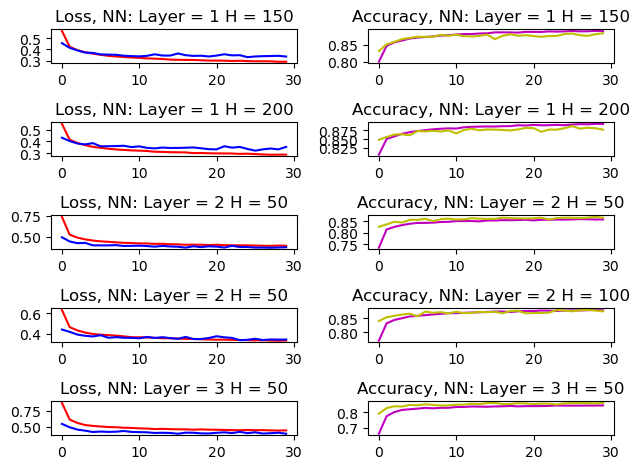

In [221]:
figure , ax = plt.subplots(5, 2)

ax[0 , 0].set_title("Loss, NN: Layer = 1 H = 150")
ax[0 , 0].plot(info_1[0] , color = 'r' , label = "Train")
ax[0, 0].plot(info_1[1] , color = 'b' , label = "Test")

ax[0 , 1].set_title("Accuracy, NN: Layer = 1 H = 150")
ax[0 , 1].plot(info_1[2] , color = 'm' , label = "Train")
ax[0 , 1].plot(info_1[3], color = 'y' , label = "Test")

ax[1 , 0].set_title("Loss, NN: Layer = 1 H = 200")
ax[1 , 0].plot(info_2[0] , color = 'r' , label = "Train")
ax[1, 0].plot(info_2[1] , color = 'b' , label = "Test")

ax[1 , 1].set_title("Accuracy, NN: Layer = 1 H = 200")
ax[1 , 1].plot(info_2[2] , color = 'm' , label = "Train")
ax[1 , 1].plot(info_2[3], color = 'y' , label = "Test")

ax[2 , 0].set_title("Loss, NN: Layer = 2 H = 50")
ax[2 , 0].plot(info_3[0] , color = 'r' , label = "Train")
ax[2, 0].plot(info_3[1] , color = 'b' , label = "Test")

ax[2 , 1].set_title("Accuracy, NN: Layer = 2 H = 50")
ax[2 , 1].plot(info_3[2] , color = 'm' , label = "Train")
ax[2 , 1].plot(info_3[3], color = 'y' , label = "Test")

ax[3 , 0].set_title("Loss, NN: Layer = 2 H = 50")
ax[3 , 0].plot(info_4[0] , color = 'r' , label = "Train")
ax[3, 0].plot(info_4[1] , color = 'b' , label = "Test")

ax[3 , 1].set_title("Accuracy, NN: Layer = 2 H = 100")
ax[3 , 1].plot(info_4[2] , color = 'm' , label = "Train")
ax[3 , 1].plot(info_4[3], color = 'y' , label = "Test")

ax[4 , 0].set_title("Loss, NN: Layer = 3 H = 50")
ax[4 , 0].plot(info_5[0] , color = 'r' , label = "Train")
ax[4, 0].plot(info_5[1] , color = 'b' , label = "Test")

ax[4 , 1].set_title("Accuracy, NN: Layer = 3 H = 50")
ax[4 , 1].plot(info_5[2] , color = 'm' , label = "Train")
ax[4 , 1].plot(info_5[3], color = 'y' , label = "Test")

figure.tight_layout()

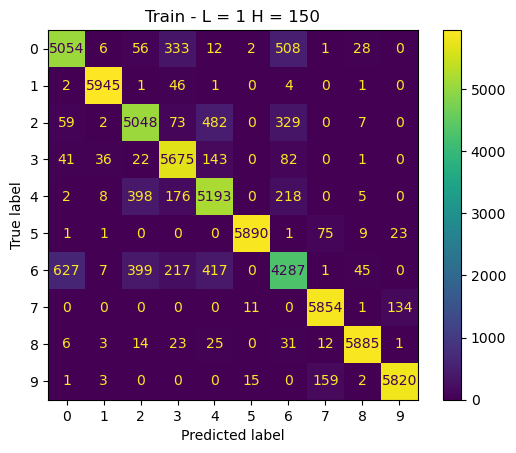

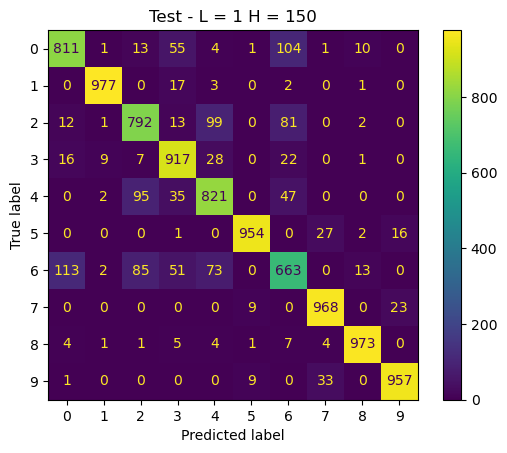

Test Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.80      0.79      0.79      1000
           3       0.84      0.92      0.88      1000
           4       0.80      0.82      0.81      1000
           5       0.98      0.95      0.97      1000
           6       0.72      0.66      0.69      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [230]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model_1(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model_1(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)


train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train - L = 1 H = 150")
plt.show()
disp_v.plot()
plt.title("Test - L = 1 H = 150")
plt.show()


print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)

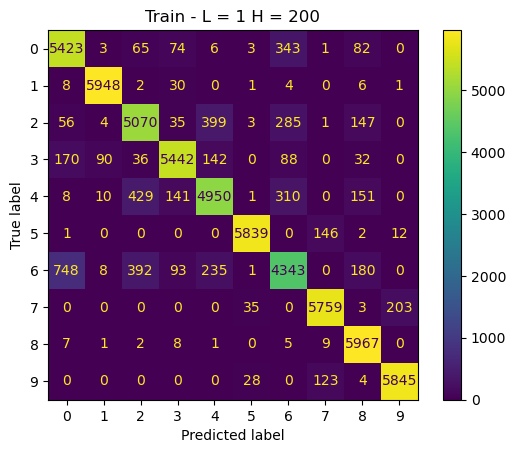

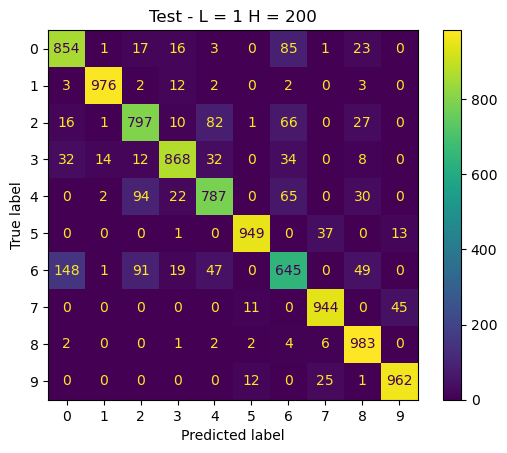

Test Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.79      0.80      0.79      1000
           3       0.91      0.87      0.89      1000
           4       0.82      0.79      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.72      0.65      0.68      1000
           7       0.93      0.94      0.94      1000
           8       0.87      0.98      0.93      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [231]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model_2(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model_2(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)


train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train - L = 1 H = 200")
plt.show()
disp_v.plot()
plt.title("Test - L = 1 H = 200")
plt.show()

print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)


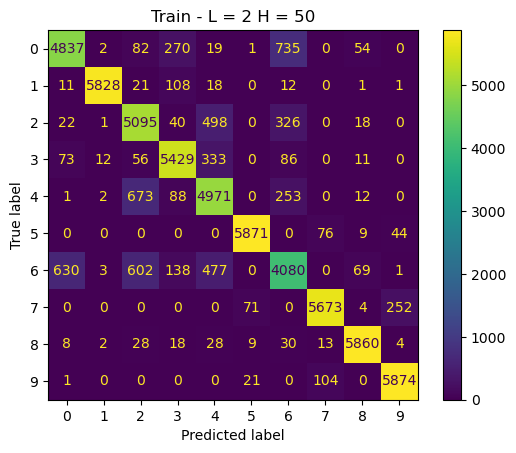

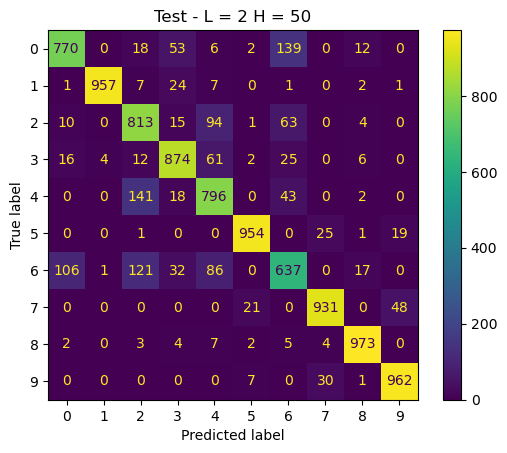

Test Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1000
           1       0.99      0.96      0.98      1000
           2       0.73      0.81      0.77      1000
           3       0.86      0.87      0.87      1000
           4       0.75      0.80      0.77      1000
           5       0.96      0.95      0.96      1000
           6       0.70      0.64      0.67      1000
           7       0.94      0.93      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [232]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model_3(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model_3(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)


train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train - L = 2 H = 50")
plt.show()
disp_v.plot()
plt.title("Test - L = 2 H = 50")
plt.show()

print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)

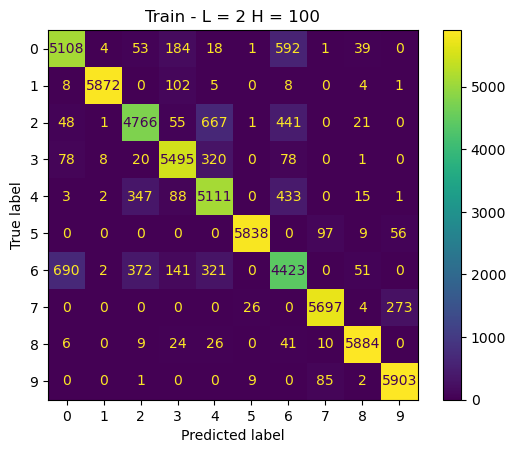

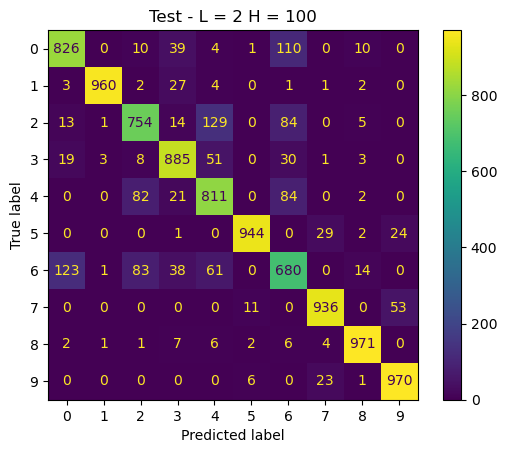

Test Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.75      0.78      1000
           3       0.86      0.89      0.87      1000
           4       0.76      0.81      0.79      1000
           5       0.98      0.94      0.96      1000
           6       0.68      0.68      0.68      1000
           7       0.94      0.94      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [233]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model_4(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model_4(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)


train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train - L = 2 H = 100")
plt.show()
disp_v.plot()
plt.title("Test - L = 2 H = 100")
plt.show()

print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)

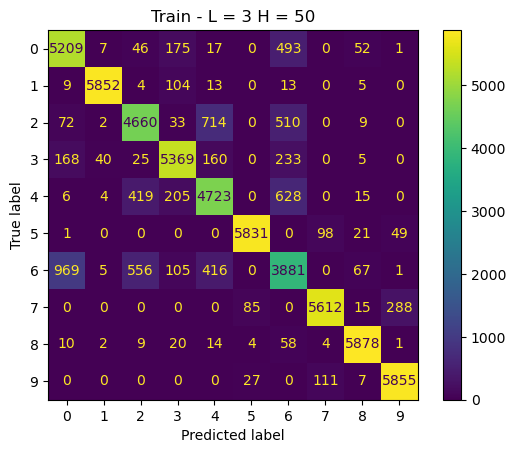

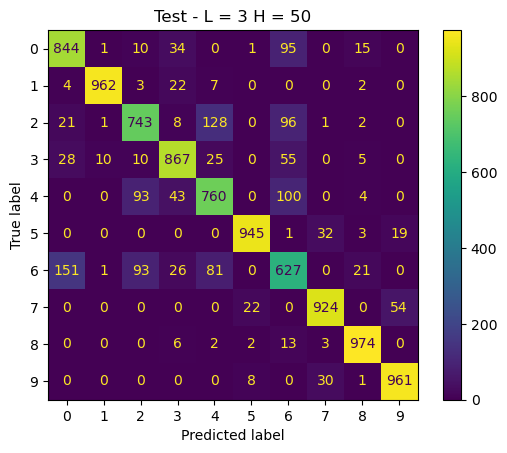

Test Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.99      0.96      0.97      1000
           2       0.78      0.74      0.76      1000
           3       0.86      0.87      0.86      1000
           4       0.76      0.76      0.76      1000
           5       0.97      0.94      0.96      1000
           6       0.64      0.63      0.63      1000
           7       0.93      0.92      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.93      0.96      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [234]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model_5(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model_5(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)


train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train - L = 3 H = 50")
plt.show()
disp_v.plot()
plt.title("Test - L = 3 H = 50")
plt.show()

print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)

# Metrics for choosing the best Structure :

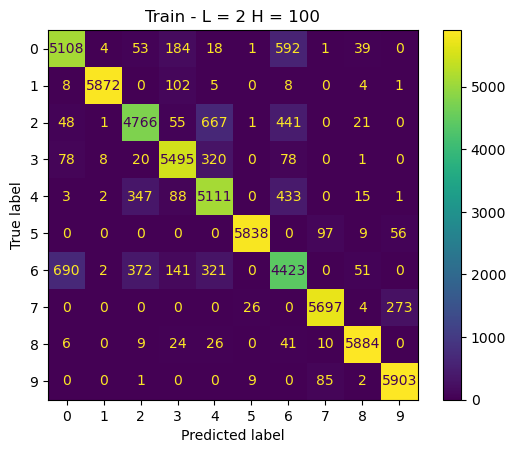

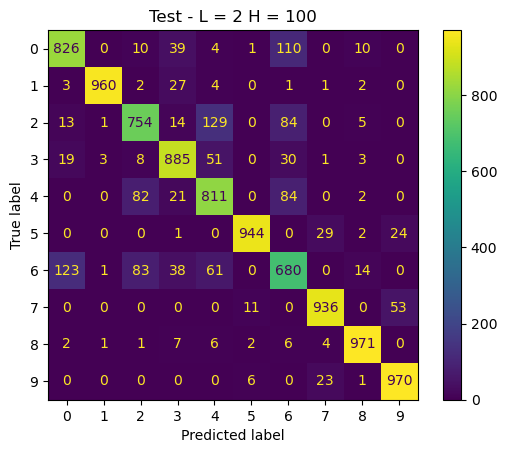

Test Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.75      0.78      1000
           3       0.86      0.89      0.87      1000
           4       0.76      0.81      0.79      1000
           5       0.98      0.94      0.96      1000
           6       0.68      0.68      0.68      1000
           7       0.94      0.94      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [235]:
train_labels = np.zeros(shape=[1 , 10])
train_predictions = np.zeros(shape=[1 , 10])
test_labels = np.zeros(shape=[1 , 10])
test_prediction = np.zeros(shape=[1 , 10])
with torch.no_grad(): 
        for inputs, labels in train_loader:
            outputs_train = model_4(inputs.to(device))
            train_labels = np.append(train_labels , labels.numpy() , axis=0)
            train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
        for inputs, labels in test_loader:
            outputs_test = model_4(inputs.to(device))
            test_labels = np.append(test_labels  , labels.numpy(), axis=0)
            test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)


train_labels  = train_labels[1: , :]
train_predictions = train_predictions[1: , :]
test_labels   = test_labels [1: , :]
test_prediction = test_prediction[1: , :]

cf_matrix_t = confusion_matrix(np.argmax(train_labels , axis=-1) , np.argmax(train_predictions , axis=-1))
cf_matrix_v = confusion_matrix(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1))

disp_t = ConfusionMatrixDisplay(cf_matrix_t)
disp_v = ConfusionMatrixDisplay(cf_matrix_v)
disp_t.plot()
plt.title("Train - L = 2 H = 100")
plt.show()
disp_v.plot()
plt.title("Test - L = 2 H = 100")
plt.show()

print("Test Report:")
report_train = classification_report(np.argmax(test_labels , axis=-1) , np.argmax(test_prediction , axis=-1) , )
print(report_train)

### Metrics for choosing the best model in classification are usually: 
#### 1- Overall Accuracy: (TP)/(Totall)
#### 2 - Overall f1 score : 2*Precision*Recall/(Precision + Recall)
#### 3- Overall Precision and Recall: TP/(TP+FP) && TP/(TP+FN)
#### 4- All the metrics above for each class, showing how Region adaptive the network is